<a href="https://colab.research.google.com/github/rutkovskii/FlightAnalysis/blob/main/RusAirtraffic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
# Imports
import pandas as pd
import requests 
from bs4 import BeautifulSoup
import re
from datetime import datetime

import matplotlib.pyplot as plt


def df_printer(df):
  with pd.option_context('display.max_rows', None,):
    print(df)

# Exctracting Data

###Working with Flight Data

In [49]:
# Read all flights for January and February 2022

# Source: https://zenodo.org/record/6325961#.YkHzUzdBxQI

flights_jan = pd.read_csv('/content/flightlist_20220101_20220131.csv.gz')
flights_feb = pd.read_csv('/content/flightlist_20220201_20220228.csv.gz')

In [50]:
# Sneakpeak
flights_jan.head()

,callsign,number,icao24,registration,typecode,origin,destination,firstseen,lastseen,day,latitude_1,longitude_1,altitude_1,latitude_2,longitude_2,altitude_2
0,QTR859,QR859,06a13c,A7-BAZ,B77W,OTHH,OTHH,2021-12-31 00:11:49+00:00,2022-01-01 02:10:29+00:00,2022-01-01 00:00:00+00:00,25.289062,51.612142,0.0,25.249096,51.629575,15.24
1,CAO1023,NaN,780bb7,B-2096,B77L,KORD,EHAM,2021-12-31 01:29:29+00:00,2022-01-01 13:23:35+00:00,2022-01-01 00:00:00+00:00,41.969030,-87.929524,304.8,52.351669,4.710938,-99.06
2,ETH724,NaN,040141,NaN,NaN,KEWR,LOWW,2021-12-31 03:26:20+00:00,2022-01-01 04:47:19+00:00,2022-01-01 00:00:00+00:00,40.688141,-74.171326,0.0,48.113159,16.563126,99.06
3,SEJ241,NaN,800d1a,NaN,NaN,VECC,VECC,2021-12-31 04:27:41+00:00,2022-01-01 03:03:58+00:00,2022-01-01 00:00:00+00:00,22.709764,88.453217,304.8,22.588852,88.440091,259.08
4,QFA7550,NaN,abb6dc,N854GT,B748,KORD,YSSY,2021-12-31 04:34:40+00:00,2022-01-01 01:30:28+00:00,2022-01-01 00:00:00+00:00,41.984067,-87.942682,304.8,-33.965630,151.181087,22.86


In [51]:
# Attempt to find Pulkovo Airport in this data set 
# Origins and Destinations are written in ICAO codes
# ICAO — International Civil Aviation Organization

# Pulkovo's ICAO code: ULLI
flights_jan.loc[flights_jan['origin'] == "ULLI"].head(10)


,callsign,number,icao24,registration,typecode,origin,destination,firstseen,lastseen,day,latitude_1,longitude_1,altitude_1,latitude_2,longitude_2,altitude_2
189344,SDM6115,NaN,4248e4,VQ-BAV,A319,ULLI,NaN,2022-01-03 16:39:52+00:00,2022-01-03 17:59:58+00:00,2022-01-03 00:00:00+00:00,59.780848,30.342818,609.6,52.193298,39.805350,10683.24
189664,PBD6822,NaN,42442e,NaN,NaN,ULLI,UUEE,2022-01-03 16:43:55+00:00,2022-01-03 17:40:19+00:00,2022-01-03 00:00:00+00:00,59.781034,30.340829,609.6,55.957233,37.320471,510.54
189843,DLH1437,LH1437,3c6758,D-AIZX,A320,ULLI,EDDF,2022-01-03 16:46:23+00:00,2022-01-03 19:25:24+00:00,2022-01-03 00:00:00+00:00,59.782562,30.334808,914.4,50.042643,8.560354,137.16
190716,FIN706,NaN,461f35,OH-LVH,A319,ULLI,EFHK,2022-01-03 16:57:51+00:00,2022-01-03 17:35:57+00:00,2022-01-03 00:00:00+00:00,59.781052,30.339844,914.4,60.315128,24.944752,205.74
191305,LOT686,NaN,48adab,NaN,NaN,ULLI,EPWA,2022-01-03 17:05:00+00:00,2022-01-03 18:43:10+00:00,2022-01-03 00:00:00+00:00,59.781326,30.339661,914.4,52.150563,20.980198,220.98
191449,SWR1311,LX1311,4b1800,HB-JCI,NaN,ULLI,LSZH,2022-01-03 17:06:40+00:00,2022-01-03 19:56:39+00:00,2022-01-03 00:00:00+00:00,59.783798,30.322174,914.4,47.476951,8.543067,411.48
192201,SDM6023,NaN,4242e9,VP-BQK,A319,ULLI,UUWW,2022-01-03 17:16:19+00:00,2022-01-03 18:16:29+00:00,2022-01-03 00:00:00+00:00,59.782013,30.332153,914.4,55.570496,37.168080,609.60
192766,AFL025,NaN,424350,VP-BFQ,A321,ULLI,UUEE,2022-01-03 17:23:17+00:00,2022-01-03 18:18:18+00:00,2022-01-03 00:00:00+00:00,59.782803,30.327948,914.4,55.950529,37.276011,716.28
193072,AUL581,NaN,424486,NaN,NaN,ULLI,NaN,2022-01-03 17:27:01+00:00,2022-01-03 19:03:58+00:00,2022-01-03 00:00:00+00:00,59.779451,30.352762,609.6,53.526627,49.574629,2590.80
193769,AUL517,NaN,4243af,NaN,NaN,ULLI,NaN,2022-01-03 17:36:20+00:00,2022-01-03 18:22:55+00:00,2022-01-03 00:00:00+00:00,59.781173,30.339787,914.4,64.748064,32.028351,11582.40


### Extracting International Airports and the Page 

In [52]:
# Getting tables with all international airports
url = "https://en.wikipedia.org/wiki/List_of_international_airports_by_country"
airport_dfs = pd.read_html(url)


In [53]:
# Getting names of the countries

url = "https://en.wikipedia.org/wiki/List_of_international_airports_by_country"
response=requests.get(url)
print(response.status_code)


200


### Getting DFs with IATA and ICAO Codes

In [54]:
# Getting codes
url = "http://www.flugzeuginfo.net/table_airportcodes_country-location_en.php"
iata_icao_dfs = pd.read_html(url)

len(iata_icao_dfs)
iata_icao_dfs[0]


,IATA,ICAO,Location,Airport,Country
0,BIM,OABN,Bamyan,Bamyan,Afghanistan
1,BST,OABT,Bost,Bost,Afghanistan
2,BPM,OAIX,Charikar,Bagram Air Base,Afghanistan
3,CCN,OACC,Charkhcharan,Charkhcharan,Afghanistan
4,FBD,OAFZ,Faizabad,Faizabad,Afghanistan
...,...,...,...,...,...
302,KLU,LOWK,Klagenfurt,Klagenfurt,Austria
303,SZG,LOWS,Salzburg,Salzburg,Austria
304,VIE,LOWW,Wien (Vienna),Wien - Schwechat,Austria
305,BAK,UBBB,Baku,Bina,Azerbaijan


### Getting Names and ICAO codes of Russian Airports

In [55]:
# Getting tables with all Russian airports

ru_aiports_raw = pd.read_html("https://en.wikipedia.org/wiki/List_of_airports_in_Russia")

# We need 1st table because it contains the relevant data
ru_aiports_raw = ru_aiports_raw[0]

#df_printer(ru_aiports)

# Cleaning Data

## Create Dataframes
Combining tables with country names

Ps. Could have actually avoided using it because ```iata_icao_dfs``` have Country names corresponding with ICAO and IATA codes



###Find Country for each table

In [56]:
soup = BeautifulSoup(response.text, 'html.parser')


# Extract all Countries before Oceania
countries = []

for level in soup.find_all('li',{'class':'toclevel-3'}):
  #hit = level.text.strip()
  country = level.find('span',{'class':'toctext'}).text.strip()
  countries.append(country)

print(len(countries))


# Extract Oceania countries
t1 = soup.find('li',{'class':"toclevel-1 tocsection-234"})

for level in t1.find_all('li',{'class':'toclevel-2'}):
  country = level.find('span',{'class':'toctext'}).text.strip()
  countries.append(country)

print(len(countries))

208
234


###Match airport codes with country naames

In [57]:
# Remove table that is not the airport table
print(len(airport_dfs))
if len(airport_dfs) > 234:
  airport_dfs.pop(0)
print(len(airport_dfs))

# Cleaning Columns and Assigning country to the airport
i = 0 
modified_airport_dfs = []
for df in airport_dfs:
  if "IATA Code" in df.columns:
    df.rename(columns={"IATA Code": "IATA"},inplace=True)
  m_df = df[["IATA","Airport"]]

  # Assigning counttry
  m_df.insert(2, 'Country', countries[i])
  modified_airport_dfs.append(m_df)

  i+=1

# Creating 1 dataframe with all international airports, but without their codes
iata_df = pd.concat(modified_airport_dfs)
iata_df.reset_index(drop=True,inplace=True)
len(iata_df)
iata_df

235
234


,IATA,Airport,Country
0,AZR,Touat-Cheikh Sidi Mohamed Belkebir Airport,Algeria
1,ALG,Houari Boumediene Airport,Algeria
2,AAE,Rabah Bitat Airport,Algeria
3,BLJ,Batna Airport,Algeria
4,BJA,Soummam Airport,Algeria
...,...,...,...
1439,FUN,Funafuti International Airport,Tuvalu
1440,SON,Santo-Pekoa International Airport,Vanuatu
1441,VLI,Bauerfield International Airport,Vanuatu
1442,FUT,Pointe Vele Airport,Wallis and Futuna


In [58]:
# Create table with all international airports and their codes

iata_icao_df = pd.concat(iata_icao_dfs)
iata_icao_df

,IATA,ICAO,Location,Airport,Country
0,BIM,OABN,Bamyan,Bamyan,Afghanistan
1,BST,OABT,Bost,Bost,Afghanistan
2,BPM,OAIX,Charikar,Bagram Air Base,Afghanistan
3,CCN,OACC,Charkhcharan,Charkhcharan,Afghanistan
4,FBD,OAFZ,Faizabad,Faizabad,Afghanistan
...,...,...,...,...,...
23,WKI,FVWT,Hwange,Hwange Town,Zimbabwe
24,KAB,FVKB,Kariba,Kariba,Zimbabwe
25,MVZ,FVMV,Masvingo,Masvingo,Zimbabwe
26,UTA,FVMU,Mutare,Mutare,Zimbabwe


###Internation Airports DF

In [59]:

# Merging iata_df and iata_icao_df
int_airport_df = pd.merge(iata_df, iata_icao_df[['IATA','ICAO']], on='IATA', how="left") #check left and right merging

# Cleaning int_airport_df
INT_AIRPORTS = int_airport_df[['IATA','ICAO','Country','Airport']].drop_duplicates(subset=['IATA'], keep='first')
INT_AIRPORTS.reset_index(drop=True,inplace=True)

# Check for duplicates 
#INT_AIRPORTS['ICAO'].value_counts()
#df = INT_AIRPORTS.loc[INT_AIRPORTS['ICAO'] == 'UGGG']
#df


###DF with Russian Airports


In [60]:
# Relevant Columns + Removing Nan in ICAO column
RU_AIRPORTS = ru_aiports_raw[["Airport name","ICAO"]].dropna(subset=['ICAO'])
RU_AIRPORTS["Country"] = "Russia"
RU_AIRPORTS.rename(columns={"Airport name": "Airport"},inplace=True)

#RU_AIRPORTS = RU_AIRPORTS.dropna(subset=['ICAO'])

# Dropping the rows with unused airports, with region names, and Simferopol, since it is not internation 
print("Size of df before:", len(RU_AIRPORTS))

discard = ["abandoned","closed","edit","Simferopol"]
RU_AIRPORTS = RU_AIRPORTS[~RU_AIRPORTS["Airport"].str.contains('|'.join(discard))]
RU_AIRPORTS.reset_index(drop=True,inplace=True)

# Check for duplicates
#print(RU_AIRPORTS['ICAO'].value_counts())

# Degugging
#df = RU_AIRPORTS.loc[RU_AIRPORTS['ICAO'] == 'UIII']
#print(df)

#Ozernaya and Sobolevo airports have the same ICAO code

print("Size of df before:", len(RU_AIRPORTS))

print(RU_AIRPORTS)
# To see names of the airports
#for row in RU_AIRPORTS["Airport"]:
# print(row)


Size of df before: 305
Size of df before: 283
                                       Airport  ICAO Country
0                              Amderma Airport  ULDD  Russia
1            Kirovsk-Apatity Airport (Khibiny)  ULMK  Russia
2                               Talagi Airport  ULAA  Russia
3                              Vaskovo Airport  ULAH  Russia
4                          Cherepovets Airport  ULWC  Russia
..                                         ...   ...     ...
278                         Ust-Tsylma Airport  UUYX  Russia
279                           Vanavara Airport  UNIW  Russia
280                             Vuktyl Airport  UUYK  Russia
281                      Zheleznogorsk Airport  UIBV  Russia
282  Sevastopol International Airport (Belbek)  URFB  Russia

[283 rows x 3 columns]


###Flights Df

In [61]:
# flights_jan
flights_jan = flights_jan[["origin","destination","day"]]
print(len(flights_feb))

# flights22
flights_feb = flights_feb[["origin","destination","day"]]
print(len(flights_feb))

# All flights df
flights = pd.concat([flights_jan,flights_feb])
print(len(flights))
print(flights.columns)


2239224
2239224
4649788
Index(['origin', 'destination', 'day'], dtype='object')


###Shorten flights DF with "origin" only containing Russian Airports 

In [62]:
# Keep only flights with NaN and Russian Airport codes in "origin" column 
FLIGHTS = flights[flights['origin'].isin(RU_AIRPORTS['ICAO'])].copy()
print(len(flights))

# Drop NaN 
FLIGHTS.dropna(inplace=True)
print(len(FLIGHTS))

# Change 'day' from str to datetime
FLIGHTS['day'] = pd.to_datetime(FLIGHTS['day'], format="%Y/%m/%d").dt.date
#flights.head(50)

4649788
24144


###Downloading Cleaned DFs


In [63]:
from google.colab import files

#FLIGHTS.to_csv("all_flights.csv")
#RU_AIRPORTS.to_csv("russian_aiports.csv")
#INT_AIRPORTS.to_csv("international_airports.csv")


#files.download("all_flights.csv")
#files.download("russian_aiports.csv")
#files.download("international_airports.csv")




# Creating Interface for people to work

*  Will be transferred to the Telegram Bot Functionality



In [64]:
user_input = input("What Day and Airport in Russia? \n" +
                  "It accepts only 'dd mm yyyy' format. \nFor example: \n" +
                   "\t01-01-2022, Sheremetyevo\n" +
                   "\t01/01/2022, Sheremetyevo\n" 
                   "\t01-January-2022, Sheremetyevo\n" + 
                   "\t01 January 2022, Sheremetyevo:  " )



What Day and Airport in Russia? 
It accepts only 'dd mm yyyy' format. 
For example: 
	01-01-2022, Sheremetyevo
	01/01/2022, Sheremetyevo
	01-January-2022, Sheremetyevo
	01 January 2022, Sheremetyevo:  01 January 2022, Sheremetyevo


*102 flight(s) were made from Sheremetyevo International Airport on 2022-01-01.

*To 61 unique destination(s).
**1st most traveled destination is Minsk International Airport, Belarus with 6 flight(s).
**2nd most traveled destination is Koltsovo International Airport, Russia with 5 flight(s).
**3rd most traveled destination is Murmansk Airport, Russia with 5 flight(s).
**4th most traveled destination is Warsaw Chopin Airport, Poland with 3 flight(s).
**5th most traveled destination is Irkutsk International Airport, Russia with 3 flight(s).


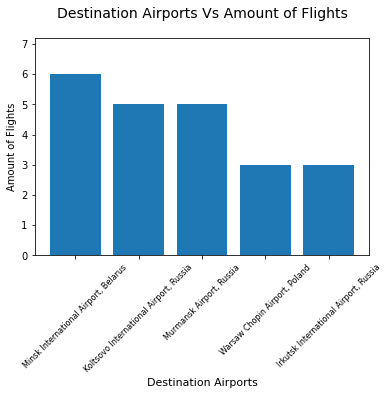

<Figure size 216x216 with 0 Axes>


*To 28 unique countries.
**1st most traveled is country Germany with 6 flight(s).
**2nd most traveled is country Italy with 3 flight(s).
**3rd most traveled is country Spain with 3 flight(s).
**4th most traveled is country United Arab Emirates with 2 flight(s).
**5th most traveled is country Switzerland with 2 flight(s).


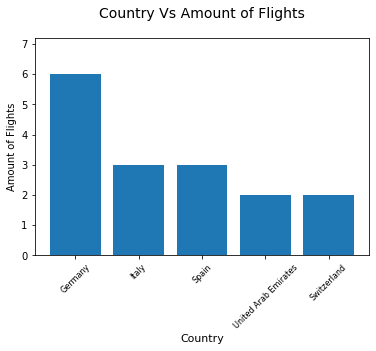

<Figure size 216x216 with 0 Axes>

In [65]:
RU_AIRPORTS_2=RU_AIRPORTS.copy()

def pop_printer(df,option:str):
  """Prints most travelled destinations or countries"""
  i=1
  for index,row in df.iterrows():
    if pd.isnull(row['Country']):
      continue

    if i == 1: suffix = "st"
    elif i == 2: suffix = "nd"
    elif i == 3: suffix = "rd"
    elif i == 4 or i == 5: suffix = "th"

    if option == "dest":
      print(f"**{i}{suffix} most traveled destination is {row['Airport']}, {row['Country']} with {row['Amount']} flight(s).")
    elif option == "country":
      print(f"**{i}{suffix} most traveled is country {row['Country']} with {row['Amount']} flight(s).")
      
    i+=1
    if i == 6: break
  
def pop_df_cleaner(df,option):
  """Creates lists with the most travelled destinations or countries to be plotted"""
  x,y = [],[]
  i=1 
  for index,row in df.iterrows():

    if pd.isnull(row['Country']):
      continue

    if option == "dest":
      if pd.isnull(row['Airport']):
        continue

    y.append(row['Amount'])
    if option == "country":
      x.append(row['Country'])
    elif option == "dest":
      x.append(row["Airport"]+', '+ row['Country'])

    i+=1
    if i == 6: break

  return x,y

def create_plt(df,option):
  """Creates the barplot with the most travelled destinations or countries"""
  x,y = pop_df_cleaner(df,option)
  plt.bar(x=x, height=y)

  ax = plt.gca()
  ax.tick_params(axis='x', labelrotation = 45)
  ax.margins(y=0.2)
  #ax.set_xticklabels(ax.get_xticks(), rotation = 45)

  if option == "dest":
    plt.title('Destination Airports Vs Amount of Flights', fontsize=14, pad=20)
    plt.xlabel('Destination Airports', fontsize=11)

  elif option == "country":
    plt.title('Country Vs Amount of Flights', fontsize=14, pad=20)
    plt.xlabel('Country', fontsize=11)

  plt.ylabel('Amount of Flights', fontsize=10)
  plt.xticks(fontsize=8)
  plt.figure(figsize=(3, 3))

  plt.show()




user_date_status, user_airport_status = False, False
while not user_date_status and not user_airport_status:
  user_date_status, user_airport_status = False, False
  # User input
  #user_input = "01 01 2022, Sheremetyevo" # "31 December 1900 Sheremetyevo" # "Abra"

  # Separate date and airport
  elements = user_input.split(',')

  # Not comma separated
  if len(elements) < 2:
    print('You forgot to add comma after date. Enter Date and Airport Again')
    continue

  # Missing airport or date
  if (elements[0] == "") or (elements[0] == ""):
    print('You forgot to add date or airport. Enter Date and Airport Again')
    continue

  # Cleaning date 
  user_date = elements[0]
  user_date.replace('-',' ').replace('/',' ')

  # Getting Date from User input
  pattern = r"\d{2} \d{2} \d{4}" + "|\d{2} \w+ \d{4}"
  match = re.search(pattern, user_date)

  # If invalid Date
  if not match:
    print('You entered invalid date. Enter Date and Airport Again')
    continue

  # Exctracting all elements in the string
  month = user_date.split(' ')[1]

  # Converting to data
  if month.isdigit():
    date = datetime.strptime(match.group(), '%d %m %Y').date()
  else: 
    date = datetime.strptime(match.group(), '%d %B %Y').date()

  #print(date)
  if date:
    user_date_status = True

  # Airport
  user_airport = elements[1].strip()

  # Find ICAO code for airport
  ru_port = RU_AIRPORTS[RU_AIRPORTS["Airport"].str.contains(user_airport)]

  if ru_port.empty:
    print('You entered incorrect airport name. Enter Date and Airport Again')
    continue

  icao = ru_port.iloc[0][1]

  if icao:
    # can be a method

    # cleaning on the day of flight 
    ru_port_flights = FLIGHTS.loc[FLIGHTS['day'] == date]


    # cleaning on origin Russian Airport and removing from-into flights
    ru_port_flights = ru_port_flights.loc[ru_port_flights['origin'] == icao]
    ru_port_flights = ru_port_flights.loc[ru_port_flights['destination'] != icao]


    ################## Statistics ##################

    #1
    num_flights = len(ru_port_flights) # Number of flights from airport
    if num_flights > 0:
      user_airport_status = True

    # df with unique destinations (not to use because does not have countiees)
    unique_dests_df = ru_port_flights["destination"].value_counts().rename_axis('ICAO').reset_index(name='Amount')
  
    #2
    num_unique_dests = unique_dests_df.shape[0] #alternatively len(unique_dests_df)

    #3 
    # Unique destinations
    most_visited_dests = INT_AIRPORTS.merge(unique_dests_df, on='ICAO', how='right')
    most_visited_dests = most_visited_dests.set_index('ICAO')
    RU_AIRPORTS_2 = RU_AIRPORTS_2.set_index('ICAO')
    most_visited_dests.update(RU_AIRPORTS_2)
    most_visited_dests.reset_index(inplace=True)
    RU_AIRPORTS_2.reset_index(inplace=True)
    most_visited_dests = most_visited_dests[["ICAO","Country","Airport","Amount"]]

 
    # Unique countries
    most_visited_countries = most_visited_dests.loc[most_visited_dests["Country"] != "Russia"].copy()
    most_visited_countries = most_visited_countries['Country'].value_counts().rename_axis('Country').reset_index(name='Amount')
    #df_printer(most_visited_countries)

    #4
    num_unique_countries = most_visited_countries.shape[0] #alternatively len(unique_dests_df)




    ################## Output ##################
    #1
    print(f"*{num_flights} flight(s) were made from {ru_port.iloc[0][0]} on {date}.\n")
    if num_flights > 0:
      #2
      print(f"*To {num_unique_dests} unique destination(s).")

      #3
      pop_printer(df=most_visited_dests,option="dest")

      #3.1
      if num_unique_dests > 2:
        create_plt(most_visited_dests,option="dest")

      #4
      print(f"\n*To {num_unique_countries} unique countries.")

      #5
      pop_printer(df=most_visited_countries,option="country")

      #5.1
      if num_unique_countries > 2:
        create_plt(most_visited_countries,option="country")


# Statistics we want:
# 1. Amount of flights from the airport
# 2. Amount  of unique destinations
# 3. To what destinations and airports and the count of flights to these destination
# 3-1. Diagram with the top travelled destinations (Matplotlib)
# 4. Amount of unique countries
# 5. To what countries and airports and the count of flights to these countries
# 5-1. Diagram with the top travelled countries (Matplotlib)

